In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import pairwise_distances
import phate
import scprep

os.chdir('../../src')
import mappings
import data_loader

In [20]:
def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

inputs = load_from_local('../data/HGDP/HGDP_PCA')
labels = load_from_local('../data/HGDP/HGDP_labels')
admix_ratios = load_from_local('../data/HGDP/HGDP_admix_ratios')

In [3]:
exp_path = '/lustre06/project/6065672/sciclun4/ActiveProjects/phate_genetics/data/HGDP'
fname = 'gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnet.hdf5'
inputs_raw, _, samples, snp_names, _ = data_loader.load_data_1000G(os.path.join(exp_path, fname))

In [4]:
import copy

def make_palette_label_order_HGDP(metadata_labels):
    # SAS -> CSA + add MID, OCE
    pop_palette_hgdp_coarse = copy.deepcopy(mappings.pop_pallette_1000G_coarse)
    pop_palette_hgdp_coarse['CSA'] = mappings.pop_pallette_1000G_coarse['SAS']
    pop_palette_hgdp_coarse.pop('SAS')

    pop_palette_hgdp_coarse['MID'] = 'grey'
    pop_palette_hgdp_coarse['OCE'] = 'yellow'

    label_order_hgdp_coarse = copy.deepcopy(mappings.label_order_1000G_coarse)
    label_order_hgdp_coarse.remove('SAS')
    label_order_hgdp_coarse += ['CSA', 'MID', 'OCE']

    # Keep original 24/26 populations (with colors), and add new ones. New pops colored using superpop
    label_order_hgdp_fine = []
    for super_pop in np.unique(metadata_labels['superpopulation']):
        for pop in np.unique(metadata_labels['population'][metadata_labels['superpopulation']==super_pop]):
            label_order_hgdp_fine.append(pop)

    # create tmp object to hold the original 26 populations
    mapping_26 = copy.deepcopy(mappings.pop_pallette_1000G_fine)
    mapping_26['GBR'] = mapping_26['CEUGBR']
    mapping_26['CEU'] = mapping_26['CEUGBR']
    mapping_26['STU'] = mapping_26['STUITU']
    mapping_26['ITU'] = mapping_26['STUITU']

    pop_palette_hgdp_fine = {}

    for super_pop in np.unique(metadata_labels['superpopulation']):
        for pop in np.unique(metadata_labels['population'][metadata_labels['superpopulation']==super_pop]):
            if pop not in mapping_26.keys():
                # just use superpop color for now
                pop_palette_hgdp_fine[pop] = pop_palette_hgdp_coarse[super_pop]
            else:
                pop_palette_hgdp_fine[pop] = mapping_26[pop]

    return pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine

pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(labels)

In [10]:
emb_list = []

for i, t in enumerate((1,5,10,20)):
    # initial 2D phate embedding
    phate_operator_2d = phate.PHATE(random_state=42, 
                                      n_components=2, 
                                      knn=5, 
                                      n_pca=None,
                                      decay=60,
                                      t=t,
                                      gamma=1.)
    phate_operator_2d.fit(inputs)
    phate_emb_2d = phate_operator_2d.transform()
    emb_list.append(phate_emb_2d)

Running PHATE on 3449 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.81 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.84 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.16 seconds.
  Calculating KMeans...
  Calculated KMeans in 5.73 seconds.
Calculated landmark operator in 6.51 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.03 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.86 seconds.
Running PHATE on 3449 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.81 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.83 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD 

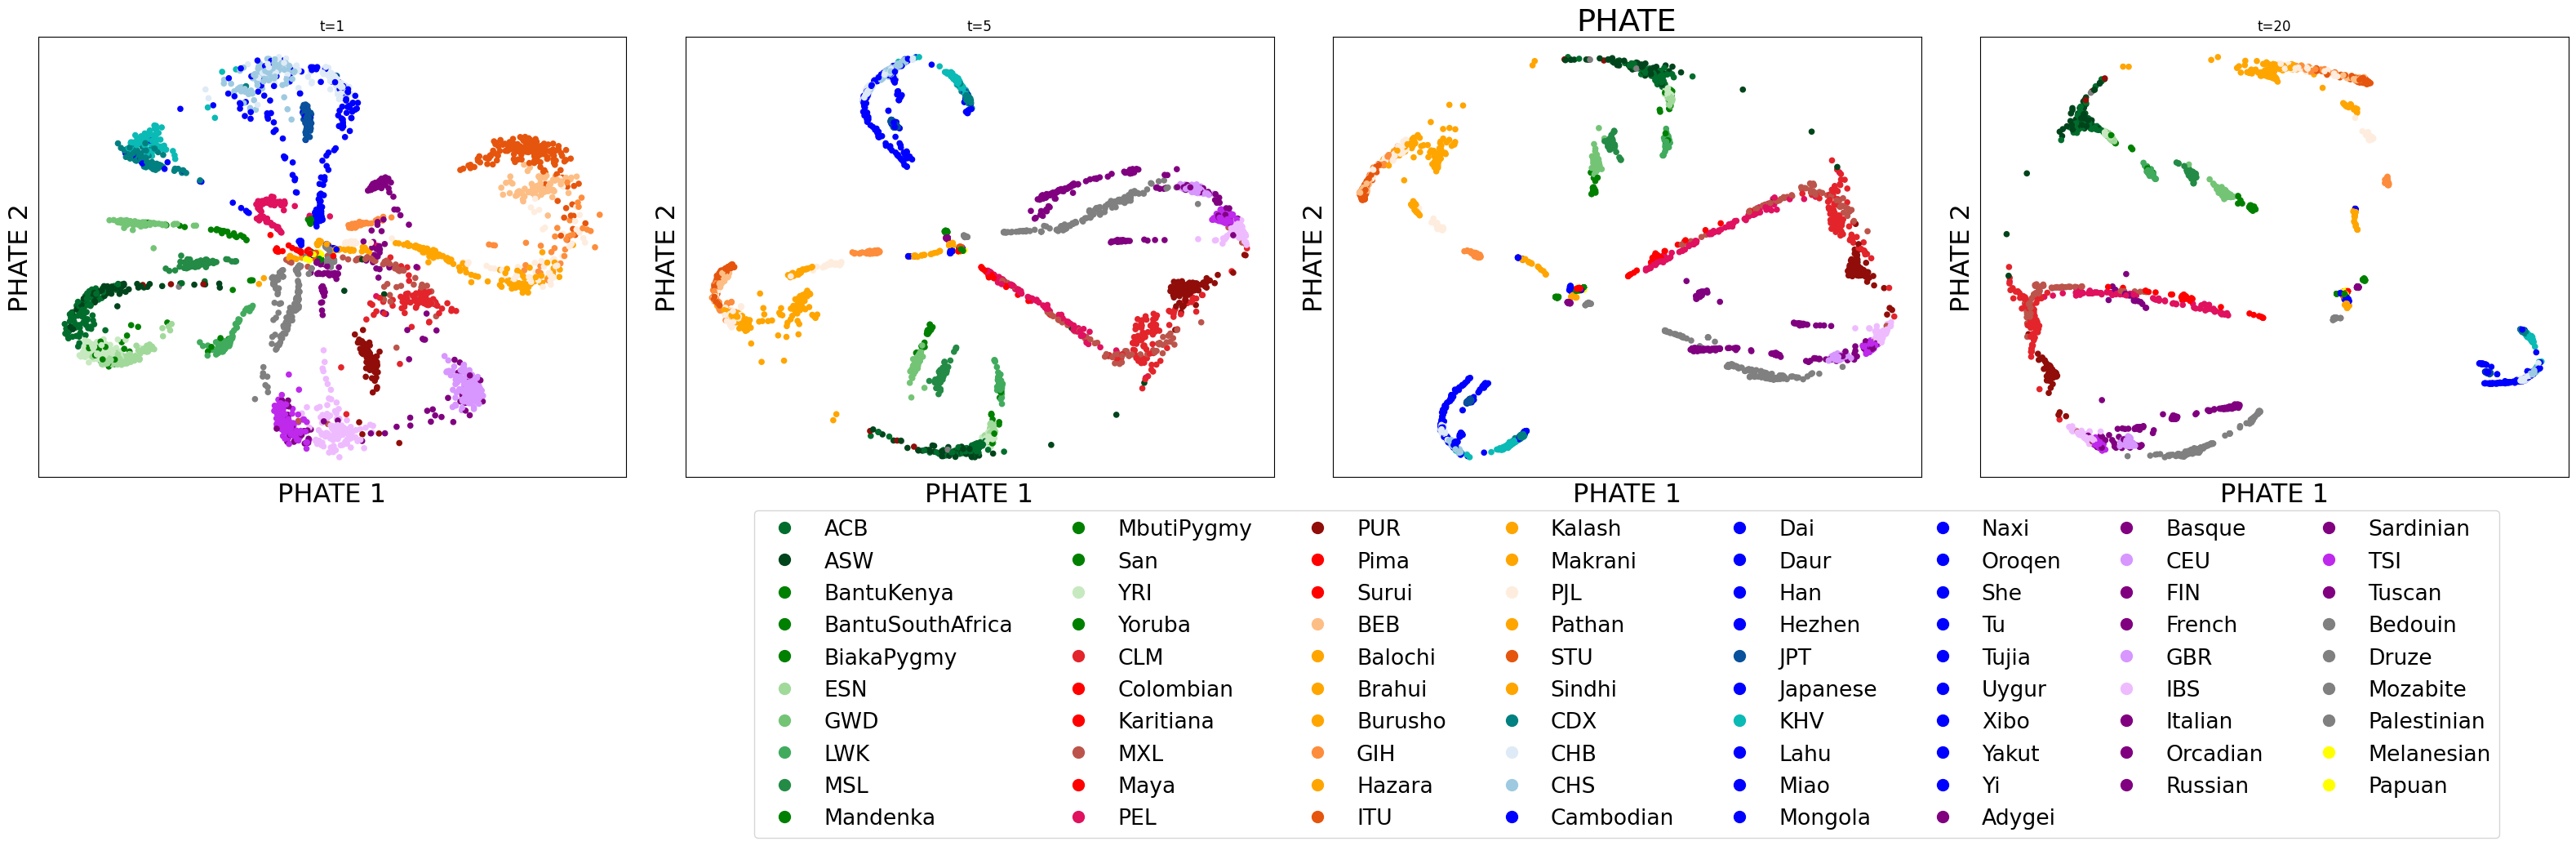

In [34]:
fig, ax = plt.subplots(1,4, figsize=(40, 7), gridspec_kw={'width_ratios': [1, 1, 1, 1], 'wspace': 0.1})

for i, t in enumerate((1,5,10,20)):
    if i == 2:
        scprep.plot.scatter2d(emb_list[i], s=20, ax=ax[i],
                              cmap=pop_palette_hgdp_fine, c=labels['population'],
                              xticks=False, yticks=False, legend=True,
                              legend_loc='upper center', legend_anchor=(0.5, -0.05), legend_ncol=8,
                              label_prefix="PHATE ",title='PHATE', fontsize=16)  
    else:
        scprep.plot.scatter2d(emb_list[i], s=20, ax=ax[i],
                              cmap=pop_palette_hgdp_fine, c=labels['population'],
                              xticks=False, yticks=False, legend=False,
                              label_prefix="PHATE ",title='PHATE', fontsize=16)
        ax[i].set_title('t={}'.format(t))
    
plt.show()

In [35]:
emb_list2 = []

for i, t in enumerate((25,40,60,100)):
    # initial 2D phate embedding
    phate_operator_2d = phate.PHATE(random_state=42, 
                                      n_components=2, 
                                      knn=5, 
                                      n_pca=None,
                                      decay=60,
                                      t=t,
                                      gamma=1.)
    phate_operator_2d.fit(inputs)
    phate_emb_2d = phate_operator_2d.transform()
    emb_list2.append(phate_emb_2d)

Running PHATE on 3449 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.80 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.83 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.16 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.25 seconds.
Calculated landmark operator in 2.14 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.80 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.07 seconds.
Running PHATE on 3449 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.80 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.83 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD 

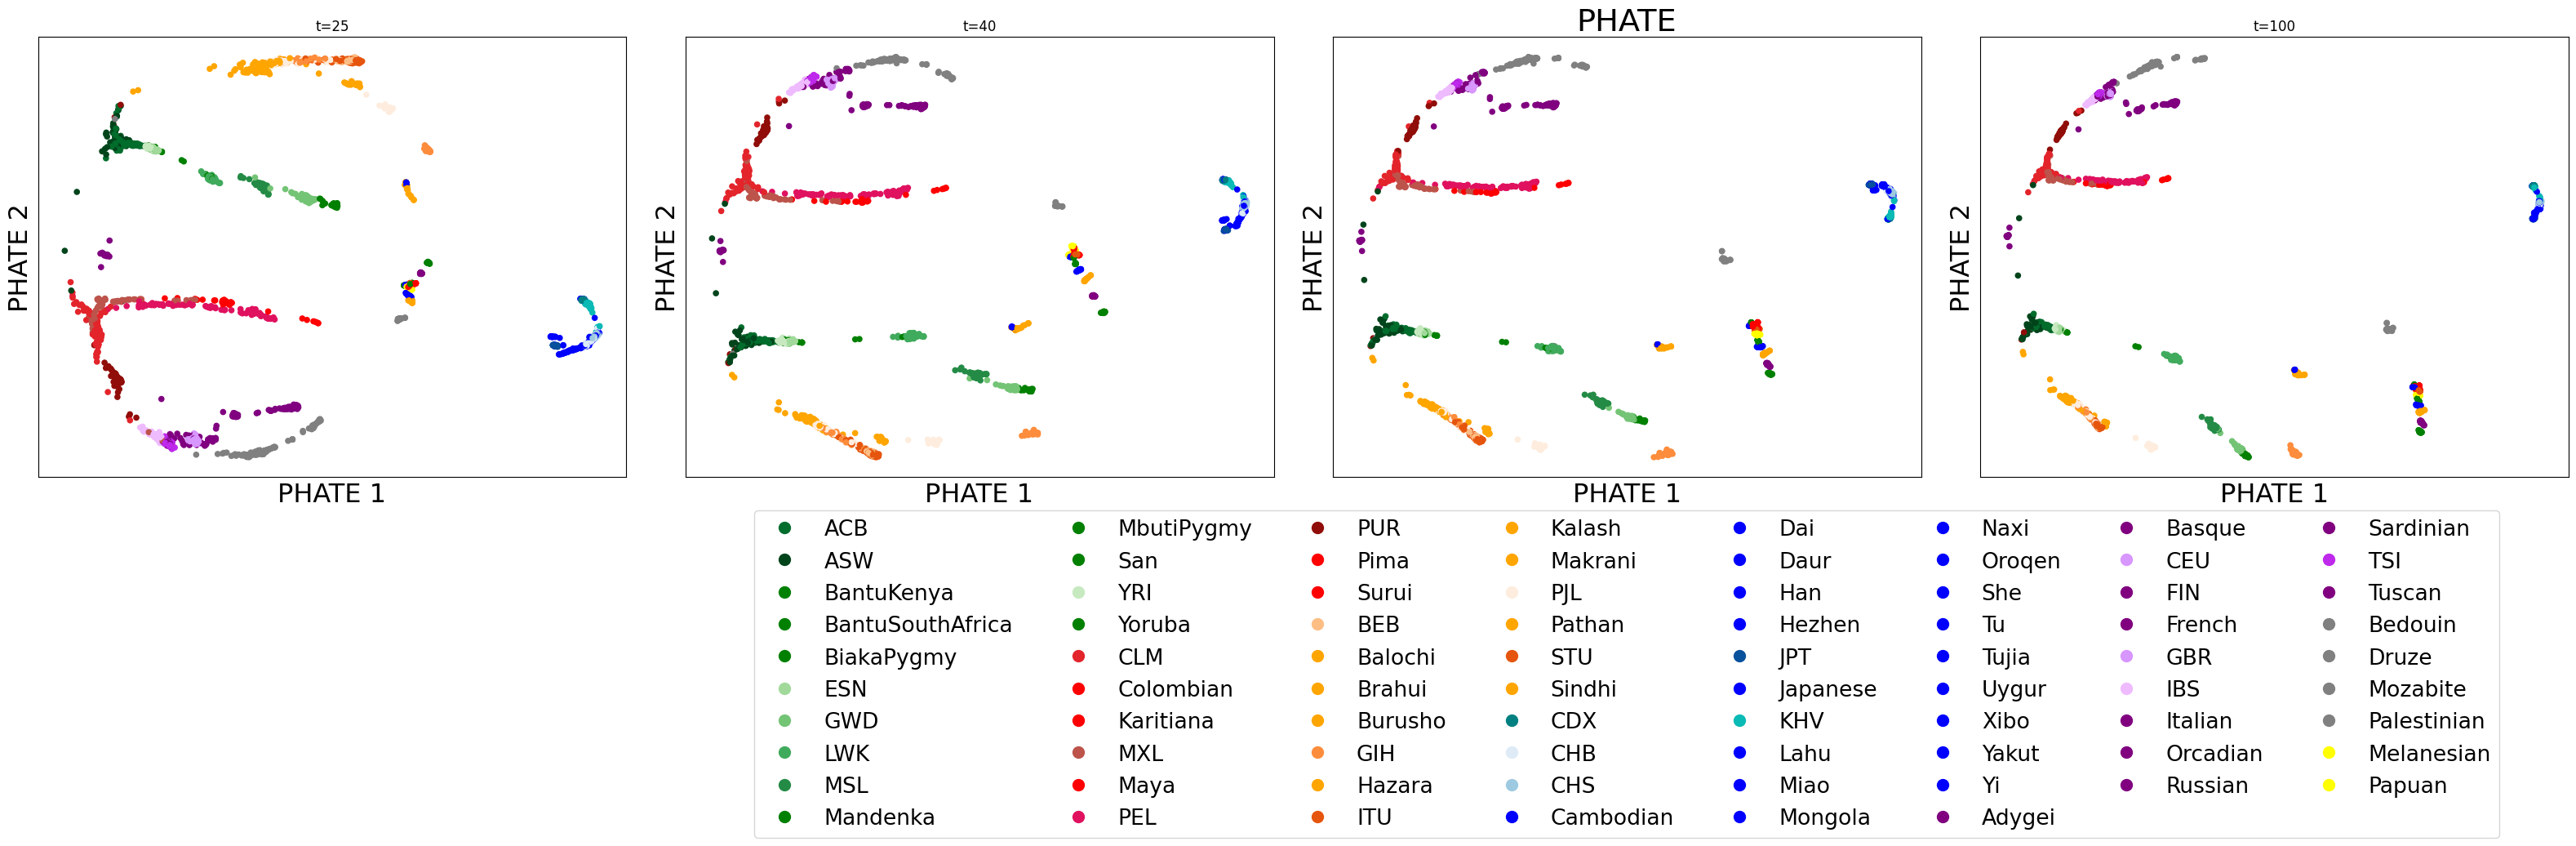

In [36]:
fig, ax = plt.subplots(1,4, figsize=(40, 7), gridspec_kw={'width_ratios': [1, 1, 1, 1], 'wspace': 0.1})

for i, t in enumerate((25,40,60,100)):
    if i == 2:
        scprep.plot.scatter2d(emb_list2[i], s=20, ax=ax[i],
                              cmap=pop_palette_hgdp_fine, c=labels['population'],
                              xticks=False, yticks=False, legend=True,
                              legend_loc='upper center', legend_anchor=(0.5, -0.05), legend_ncol=8,
                              label_prefix="PHATE ",title='PHATE', fontsize=16)  
    else:
        scprep.plot.scatter2d(emb_list2[i], s=20, ax=ax[i],
                              cmap=pop_palette_hgdp_fine, c=labels['population'],
                              xticks=False, yticks=False, legend=False,
                              label_prefix="PHATE ",title='PHATE', fontsize=16)
        ax[i].set_title('t={}'.format(t))
    
plt.show()

## Admix Ratios

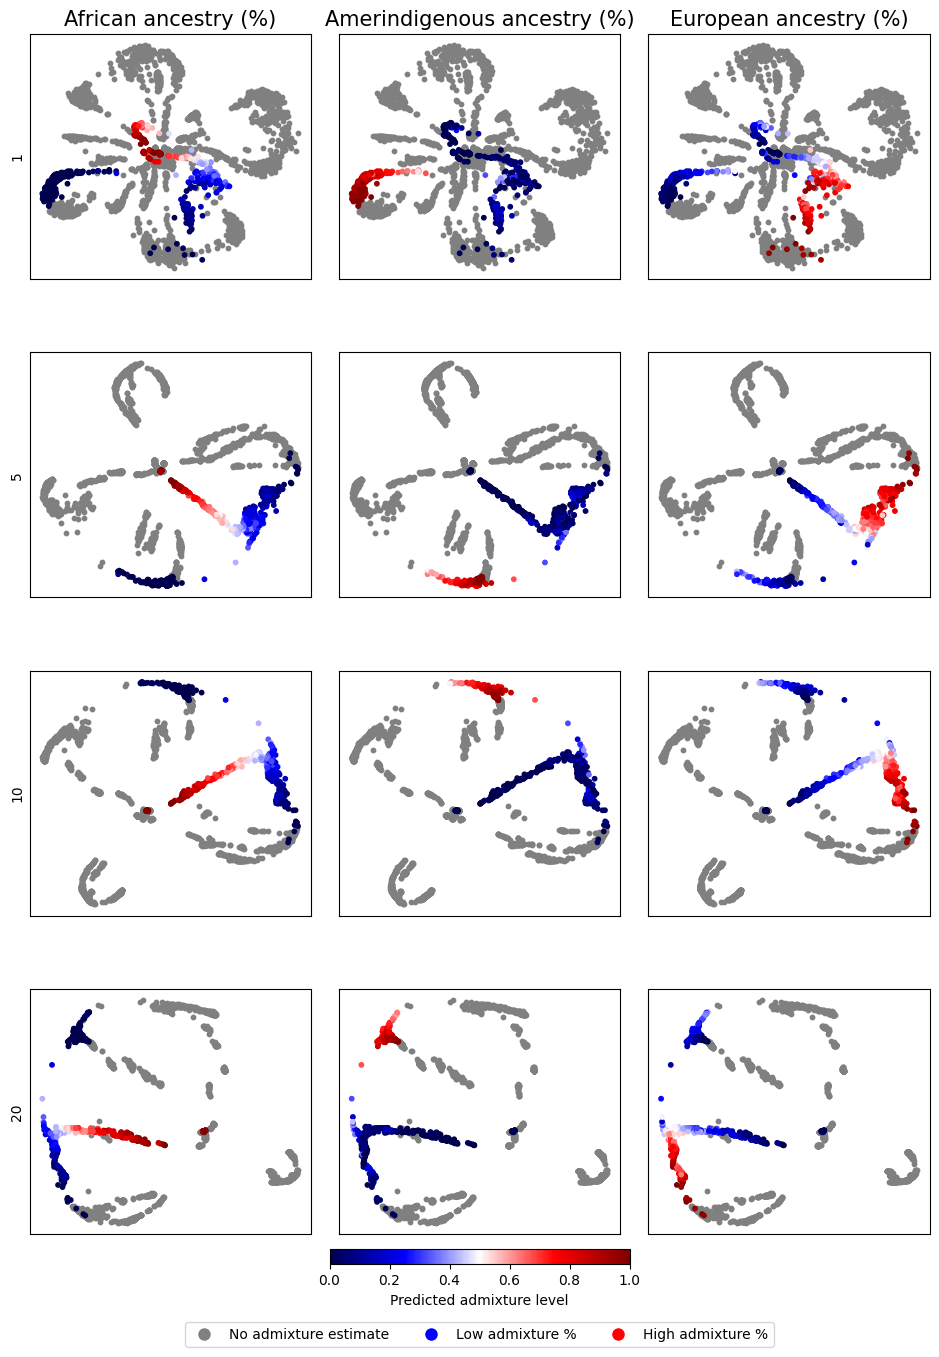

In [42]:
# plot admixture function
def plot_admixture(embedding, admix_ratios, ax, label_prefix = None):
    for col, score_name in enumerate(admix_ratios.columns):
        has_admixed_estimate = admix_ratios[score_name] > 0

        scatter_no_admix = scprep.plot.scatter2d(embedding[~has_admixed_estimate], 
                                                 s=10, 
                                                 ax=ax[col],
                                                 color=[0.5, 0.5, 0.5, 1], 
                                                 xticks=False, 
                                                 yticks=False, 
                                                 legend=False,
                                                 label_prefix=label_prefix, 
                                                 fontsize=18)
        scatter_admix = scprep.plot.scatter2d(embedding[has_admixed_estimate], 
                                              s=10, ax=ax[col],
                                              c=admix_ratios[score_name][has_admixed_estimate], 
                                              xticks=False, 
                                              yticks=False, 
                                              legend=False,
                                              label_prefix=label_prefix, 
                                              fontsize=18, 
                                              cmap='seismic')

    # Add custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='No admixture estimate'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Low admixture %'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High admixture %')
    ]

    return scatter_no_admix, scatter_admix, legend_elements

# plot admixture using PCA
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 15), gridspec_kw={'wspace': 0.1})

for row, (embs, t) in enumerate(zip(emb_list, (1,5,10,20))):
    scatter_no_admix, scatter_admix, legend_elements= plot_admixture(embs, admix_ratios, ax[row])
    ax[row, 0].set_ylabel(t) # only first column

for i, score_name in enumerate(admix_ratios.columns):
    ax[0, i].set_title(score_name, fontsize=15)

# Add colorbar
cbar_ax = fig.add_axes([0.35, 0.13, 0.3, 0.01])  # Adjust these values as needed for position and size
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.seismic), cax=cbar_ax, orientation='horizontal', fraction=0.02)
cbar.set_label('Predicted admixture level')

# add legend
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.07), ncol=3)

# Manually adjust the layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, hspace=0.3, wspace=0.3)

plt.show()